In [39]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (device)

In [2]:
#load data
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')

In [3]:
train_cycles = list(set(np.array(train_df['Cycle_Index'])))
test_cycles = list(set(np.array(test_df['Cycle_Index'])))

In [14]:
train_voltage = []
train_current = []
train_temp = []
train_charge_cap = []
train_discharge_cap = []
for i in train_cycles:
    dat = train_df[train_df['Cycle_Index'] == i]
    train_voltage.append(np.array(dat['Voltage(V)']))
    train_current.append(np.array(dat['Current(A)']))
    train_temp.append(np.array(dat['Aux_Temperature(℃)_1']))
    train_charge_cap.append(np.array(dat['Charge_Capacity(Ah)']))
    train_discharge_cap.append(np.array(dat['Discharge_Capacity(Ah)']))

In [15]:
#maximum length of time series is 362, so prepend zeros to make same length
train_data =[]
for i in range(0, len(train_cycles)):
    d1 = list(np.zeros(362-len(train_voltage[i]))) + list(train_voltage[i])
    d2 = list(np.zeros(362-len(train_current[i]))) + list(train_current[i])
    d3 = list(np.zeros(362-len(train_charge_cap[i]))) + list(train_charge_cap[i])
    d4 = list(np.zeros(362-len(train_temp[i]))) + list(train_temp[i])
    train_data.append([d1, d2, d3, d4])
train_data = np.array(train_data)

In [16]:
train_labels = [train_discharge_cap[i][-1] for i in range(0, len(train_discharge_cap))]

In [17]:
test_voltage = []
test_current = []
test_temp = []
test_charge_cap = []
test_discharge_cap = []
for i in test_cycles:
    dat = test_df[test_df['Cycle_Index'] == i]
    test_voltage.append(np.array(dat['Voltage(V)']))
    test_current.append(np.array(dat['Current(A)']))
    test_temp.append(np.array(dat['Aux_Temperature(℃)_1']))
    test_charge_cap.append(np.array(dat['Charge_Capacity(Ah)']))
    test_discharge_cap.append(np.array(dat['Discharge_Capacity(Ah)']))

test_data =[]
for i in range(0, len(test_cycles)):
    d1 = list(np.zeros(362-len(test_voltage[i]))) + list(test_voltage[i])
    d2 = list(np.zeros(362-len(test_current[i]))) + list(test_current[i])
    d3 = list(np.zeros(362-len(test_charge_cap[i]))) + list(test_charge_cap[i])
    d4 = list(np.zeros(362-len(test_temp[i]))) + list(test_temp[i])
    test_data.append([d1, d2, d3, d4])
test_data = np.array(test_data)

test_labels = [test_discharge_cap[i][-1] for i in range(0, len(test_discharge_cap))]

In [25]:
train_tensor = torch.tensor(train_data)
test_tensor = torch.tensor(test_data)
train_label = torch.tensor(train_labels)
test_label = torch.tensor(test_labels)

In [30]:
train_label = train_label.view(171, 1) 
test_label = test_label.view(43, 1)

In [31]:
print (train_label.shape)
print (test_label.shape)

torch.Size([171, 1])
torch.Size([43, 1])


In [8]:
print(np.shape(train_data))

(171, 4, 362)


In [9]:
#define the CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1))
        self.layer3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1))
        self.layer4 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1))
        self.layer5 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1))
        self.layer6 = nn.Sequential(
            nn.Linear(16*357, 16*1024),
            nn.BatchNorm1d(16*1024),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Linear(16*1024, 16*256),
            nn.BatchNorm1d(16*256),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Linear(16*256, 16*64),
            nn.BatchNorm1d(16*64),
            nn.ReLU())
        self.outlayer = nn.Linear(16*64, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.outlayer(out)
        return out

In [10]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [54]:
model = ConvNet()
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [61]:
loss_list = []
loss_list_test = []
for epoch in range(0, 100):
    
    #forward pass
    output = model(train_tensor.float())
    loss = criterion(output, train_label)
    loss_list.append(loss.item())
    
    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #prediction
    with torch.no_grad():
        test_out = model(test_tensor.float())
        test_loss = criterion(test_out, test_label)
        loss_list_test.append(test_loss.item())

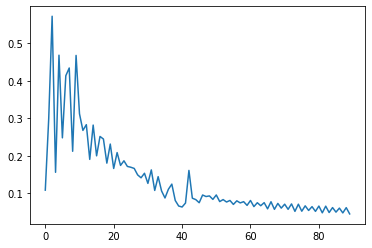

In [62]:
plt.plot(loss_list[10:])

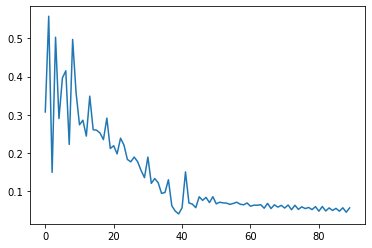

In [63]:
plt.plot(loss_list_test[10:])

In [64]:
#evaluate model
model.eval()
with torch.no_grad():
    test_out = model(test_tensor.float())
    test_loss = criterion(test_out, test_label)
print (test_loss)
for i in range(0, 43):
    print (test_label[i], test_out[i])

tensor(0.0569)
tensor([2.1854]) tensor([2.1417])
tensor([2.5116]) tensor([2.4254])
tensor([2.3120]) tensor([2.2430])
tensor([2.3154]) tensor([2.2491])
tensor([2.4350]) tensor([2.4008])
tensor([2.3133]) tensor([2.2405])
tensor([2.0516]) tensor([1.9962])
tensor([2.6355]) tensor([2.5691])
tensor([2.3123]) tensor([2.2363])
tensor([2.3084]) tensor([2.2436])
tensor([2.0539]) tensor([2.0152])
tensor([2.0288]) tensor([1.9818])
tensor([2.0146]) tensor([1.9460])
tensor([2.0023]) tensor([1.9636])
tensor([2.6274]) tensor([2.5589])
tensor([2.3035]) tensor([2.2425])
tensor([1.8940]) tensor([1.8397])
tensor([2.2991]) tensor([2.2068])
tensor([1.8690]) tensor([1.8306])
tensor([2.2934]) tensor([2.2302])
tensor([1.8510]) tensor([1.8167])
tensor([2.2940]) tensor([2.2362])
tensor([2.2310]) tensor([2.1546])
tensor([1.8050]) tensor([1.7647])
tensor([1.7948]) tensor([1.7513])
tensor([2.2739]) tensor([2.2046])
tensor([1.7846]) tensor([1.7572])
tensor([1.7818]) tensor([1.7343])
tensor([2.2775]) tensor([2.2199])